In [8]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
# Note, I suppress this future warning because Pandas is throwing a false positive. I've indicated where this warning was in the notebook below.
pd.set_option('mode.chained_assignment', None)

In [12]:
df = pd.read_csv("../../data/arxiv.csv")
df.head()
df.shape

(16000, 10)

In [10]:
test = df["published"].apply(lambda x: x.split('T')[0])
dates = [datetime(int(i.split("-")[0]), int(i.split("-")[1]), int(i.split("-")[2])) for i in test]

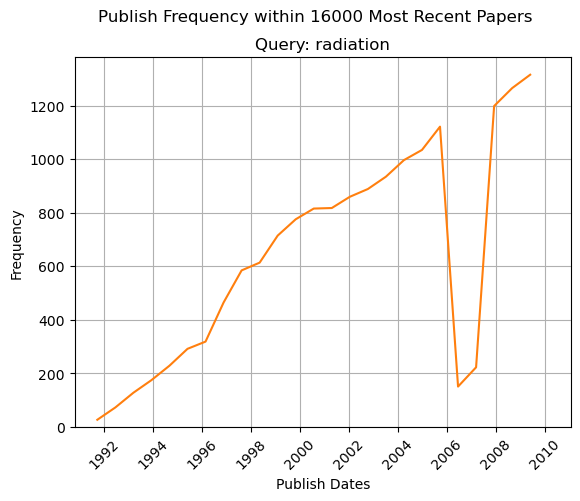

In [11]:
plt.title(f"Query: {df['query'][0]}")
plt.suptitle(f"Publish Frequency within {len(dates)} Most Recent Papers")
plt.xlabel("Publish Dates")
plt.ylabel("Frequency")
plt.grid("True")
plt.xticks(rotation=45)
counts, bins, bars = plt.hist(dates, 25, alpha=0)
plt.plot(bins[:-1], counts)
plt.show()

In [49]:
import random

def generate_counts(num_classes):
    probabilities = [random.random() for _ in range(num_classes)]
    total = sum(probabilities)
    probabilities = [p / total for p in probabilities]
    return probabilities

def generate_data(probabilities, num_samples):
    data = random.choices(range(len(probabilities)), probabilities, k=num_samples)
    return data

num_classes = 6
num_samples = 10000
data = generate_data(generate_counts(num_classes), num_samples)
data

[5,
 2,
 1,
 5,
 1,
 1,
 4,
 4,
 2,
 1,
 3,
 3,
 1,
 5,
 4,
 2,
 2,
 1,
 2,
 3,
 0,
 1,
 1,
 0,
 2,
 1,
 1,
 4,
 5,
 3,
 5,
 1,
 4,
 2,
 1,
 2,
 3,
 1,
 2,
 1,
 5,
 2,
 1,
 2,
 2,
 3,
 2,
 1,
 5,
 2,
 5,
 1,
 1,
 2,
 4,
 5,
 0,
 2,
 4,
 1,
 5,
 1,
 2,
 1,
 2,
 4,
 5,
 4,
 5,
 1,
 1,
 2,
 4,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 5,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 3,
 2,
 2,
 0,
 2,
 3,
 2,
 1,
 1,
 5,
 1,
 2,
 1,
 1,
 5,
 1,
 2,
 2,
 1,
 2,
 3,
 4,
 1,
 0,
 4,
 1,
 0,
 2,
 4,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 4,
 2,
 3,
 3,
 2,
 3,
 3,
 4,
 1,
 1,
 1,
 1,
 2,
 5,
 4,
 5,
 1,
 4,
 1,
 1,
 1,
 1,
 2,
 0,
 2,
 3,
 4,
 1,
 2,
 5,
 1,
 1,
 2,
 5,
 3,
 1,
 1,
 3,
 5,
 2,
 5,
 5,
 5,
 1,
 1,
 2,
 4,
 5,
 2,
 5,
 1,
 4,
 3,
 2,
 1,
 1,
 1,
 2,
 4,
 4,
 3,
 4,
 1,
 5,
 3,
 4,
 5,
 1,
 2,
 4,
 3,
 2,
 4,
 1,
 5,
 5,
 5,
 5,
 5,
 3,
 5,
 1,
 5,
 2,
 2,
 1,
 4,
 3,
 2,
 1,
 4,
 1,
 2,
 2,
 2,
 1,
 4,
 1,
 2,
 2,
 4,
 2,
 2,
 1,
 2,
 3,
 3,
 2,
 3,
 2,
 2,


In [66]:
big_data = [generate_data(generate_counts(num_classes), num_samples) for i in range(3)]
sources = ["arXiv", "Scopus", "Web of Science"]
class_labels = ["radiation", "plasmonics", "supervised learning", "reinforcement learning", "chloroplasts", "thylakoid"]
classes = [i for i in range(6)]
big_counts = [[data.count(i) for i in classes] for data in big_data]
big_values = [[big_counts[i][j] for i in range(len(big_data))] for j in range(len(class_labels))]

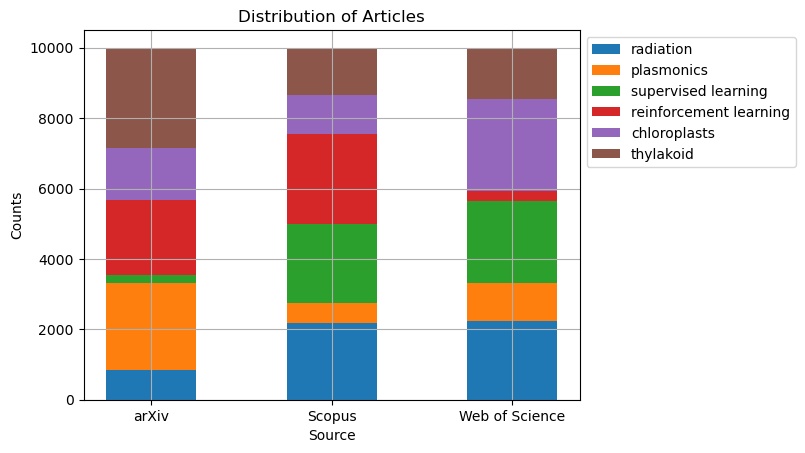

In [67]:
weight_counts = {}
for i in range(len(class_labels)):
    weight_counts[class_labels[i]] = big_values[i]

width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(3)

for boolean, weight_count in weight_counts.items():
    p = ax.bar(sources, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

plt.title(f"Distribution of Articles")
plt.xlabel("Source")
plt.ylabel("Counts")
plt.grid("True")
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

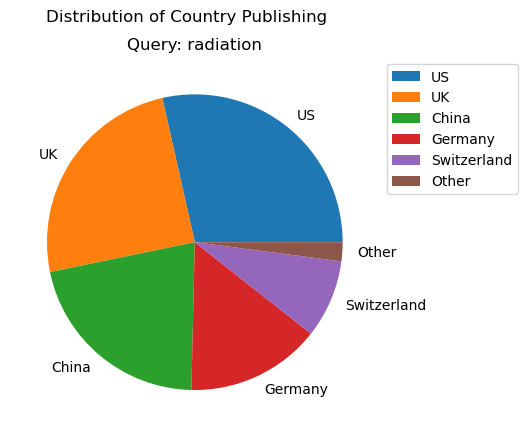

In [87]:
countries = ["US", "UK", "China", "Germany", "Switzerland", "Other"]
plt.suptitle(f"Distribution of Country Publishing")
plt.title(f"Query: {df['query'][0]}")
plt.grid("True")
values = sorted(big_counts[0], reverse=True)
plt.pie(values, labels=countries)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()